# Setup

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann
!pip install git+git://github.com/altair-viz/altair.git

  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-pmel8ihv
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-pmel8ihv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import manifold
from time import process_time
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import altair as alt

In [3]:
def plot_pred_ratings(pred,y_true,alpha=0.1):
    plt.scatter(range(0,len(y_true)),y_true,label='True')
    plt.scatter(range(0,len(pred)),pred,c='r',alpha=alpha,label='Pred')
    plt.legend()
    plt.show()

def plotting_history(rmse, val_rmse, loss, val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(rmse, label='Training RMSE')
  plt.plot(val_rmse, label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.ylabel('RMSE')
  # plt.ylim([min(plt.ylim()),1])
  # plt.ylim([0,1.0])
  plt.title('Training and Validation RMSE')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  # plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show() 

In [4]:
# Load ratings dataset from 100K MovieLens
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split='train')
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


In [5]:
ratings_df = tfds.as_dataframe(ratings)
movies_df = tfds.as_dataframe(movies)

In [49]:
ratings_df.info()
movies_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float64
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float64
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float64
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB
<class 'tensorflow_datasets.core.as_dataframe.Style

In [86]:
ratings_df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [4]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)
  # print(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [6]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)
  print(x['movie_genres'])

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}
[4]


In [5]:
# ratings = ratings.map(lambda x: {
#     "movie_title": x["movie_title"],
#     "user_id": x["user_id"],
# })
movies = movies.map(lambda x: x["movie_title"])

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

In [32]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'user_id': b'138',
 'user_rating': 4.0}


In [33]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

b'You So Crazy (1994)'


# 1.Splitting dataset

In [6]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100000, seed=42, reshuffle_each_iteration=False)

train_set = shuffled.take(80000)
val_set = shuffled.skip(80000).take(20000)
test_set = shuffled.skip(60000).take(20000)

### 1.1 For Retrival stage

In [39]:
movie_titles = movies.batch(1000)
user_ids = ratings.batch(1000000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# unique_movie_titles[:10]
len(unique_movie_titles)

1664

### 1.2 For Ranking stage

In [7]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# 2.Implementing the Basic Retrival model

In [8]:
embedding_dim = 35

In [14]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dim)
])

## Candidate Tower

In [15]:
movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dim)
])

## Choosing metric

In [16]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

## Choosing loss

In [17]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

## Put into a full model: Basic Retrival

In [18]:
class MovielensModel(tfrs.Model):

  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # pick user features and pass to user model
    user_embeddings = self.user_model(features["user_id"])

    positive_movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, positive_movie_embeddings)

## Fitting and evaluating the model
The optimizer is Adagrad with learning_rate = 0.1

In [19]:
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Shuffle the batch, and cache the training and evaluation data.

In [20]:
cached_train = train_set.shuffle(100000).batch(8192).cache()
cached_test = test_set.batch(4096).cache()

### Train the model

In [21]:
model.fit(cached_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 9s 496ms/step - factorized_top_k/top_1_categorical_accuracy: 1.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0045 - factorized_top_k/top_50_categorical_accuracy: 0.0468 - factorized_top_k/top_100_categorical_accuracy: 0.1147 - loss: 69786.3722 - regularization_loss: 0.0000e+00 - total_loss: 69786.3722
Epoch 2/10
10/10 [==============================] - 5s 476ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0121 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.1436 - factorized_top_k/top_100_categorical_accuracy: 0.2641 - loss: 67424.5675 - regularization_loss: 0.0000e+00 - total_loss: 67424.5675
Epoch 3/10
10/10 [==============================] - 5s 491ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_acc

In [22]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 3s 276ms/step - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0031 - factorized_top_k/top_10_categorical_accuracy: 0.0087 - factorized_top_k/top_50_categorical_accuracy: 0.0809 - factorized_top_k/top_100_categorical_accuracy: 0.1770 - loss: 31786.2279 - regularization_loss: 0.0000e+00 - total_loss: 31786.2279


{'factorized_top_k/top_100_categorical_accuracy': 0.1770000010728836,
 'factorized_top_k/top_10_categorical_accuracy': 0.008700000122189522,
 'factorized_top_k/top_1_categorical_accuracy': 0.0001500000071246177,
 'factorized_top_k/top_50_categorical_accuracy': 0.08089999854564667,
 'factorized_top_k/top_5_categorical_accuracy': 0.003100000089034438,
 'loss': 28870.892578125,
 'regularization_loss': 0,
 'total_loss': 28870.892578125}

## Making Prediction

In [25]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations
user_id = str(42)
_, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {titles[0, :3]}")

Recommendations for user 42: [b'Unstrung Heroes (1995)' b'Rent-a-Kid (1995)' b'Black Sheep (1996)']


# 3.Implement the Ranking model

In [8]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 35

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.3),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  def call(self, inputs):
    high = 5.0
    low = 0.5

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)
    # self.outputs = tf.keras.layers.Dense(1, activation='sigmoid')(self.ratings(tf.concat([user_embedding, movie_embedding], axis=1)))

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))*(high-low) + low

__Test this ranking model__
+ __Inputs:__ user_id and movie_name
+ __Output:__ predicted rating of the user on the movie

In [53]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.7457094]], dtype=float32)>

## Choosing loss function and metrics

Metrics: RMSE

## Put into a full model: Ranking

In [10]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [11]:
ranking_model = MovielensModel()
# ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.09))
ranking_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [12]:
cached_train = train_set.shuffle(100000).batch(8192).cache()
cached_test = test_set.batch(4096).cache()
cached_val = val_set.batch(4096).cache()

## Fitting and evaluating the Ranking model

### Train the model

In [13]:
history_ranking = ranking_model.fit(cached_train, 
                                    validation_data=cached_val, 
                                    epochs=100, 
                                    callbacks = [reduce_lr])

Epoch 1/100
10/10 [==============================] - 6s 222ms/step - root_mean_squared_error: 1.2891 - loss: 1.6395 - regularization_loss: 0.0000e+00 - total_loss: 1.6395 - val_root_mean_squared_error: 1.1744 - val_loss: 1.3529 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3529
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - root_mean_squared_error: 1.1131 - loss: 1.2344 - regularization_loss: 0.0000e+00 - total_loss: 1.2344 - val_root_mean_squared_error: 1.0841 - val_loss: 1.1525 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1525
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - root_mean_squared_error: 1.0500 - loss: 1.0960 - regularization_loss: 0.0000e+00 - total_loss: 1.0960 - val_root_mean_squared_error: 1.0076 - val_loss: 0.9988 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9988
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - root_mean_squared_error: 0.9815 - loss: 0.9630 - regularizati

In [14]:
ranking_model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 2s 16ms/step - root_mean_squared_error: 0.8177 - loss: 0.6694 - regularization_loss: 0.0000e+00 - total_loss: 0.6694


{'loss': 0.6730568408966064,
 'regularization_loss': 0,
 'root_mean_squared_error': 0.8176826238632202,
 'total_loss': 0.6730568408966064}

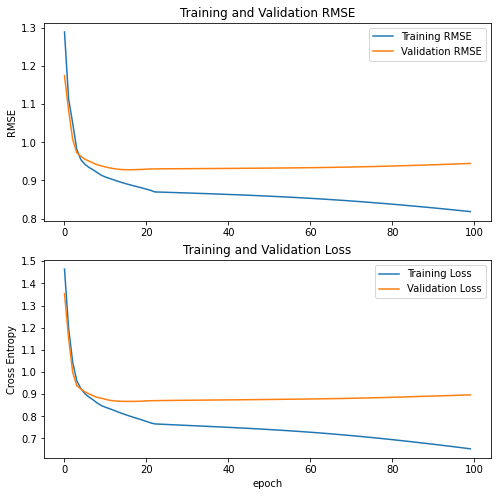

In [15]:
rmse = history_ranking.history['root_mean_squared_error']
val_rmse = history_ranking.history['val_root_mean_squared_error']

loss = history_ranking.history['loss']
val_loss = history_ranking.history['val_loss']

plotting_history(rmse, val_rmse, loss, val_loss)

### Saving the model

In [32]:
import datetime, os
curr_date = str(datetime.datetime.now().year) + '_' + str(datetime.datetime.now().month) + '_' + str(datetime.datetime.now().day)
model_folder = '/content/gdrive/MyDrive/Colab_Notebooks/XProject/model'
model_path = os.path.join(model_folder, f'ranking_model_w_{curr_date}')

# ranking_model.save_weights(model_path)
# ranking_model.save(model_path)
tf.saved_model.save(ranking_model, model_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/XProject/model/ranking_model_w_2021_10_14/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab_Notebooks/XProject/model/ranking_model_w_2021_10_14/assets


### Loding the model

In [37]:
# Assign the model
loaded_ranking_model = MovielensModel()
# load_ranking_model = tf.saved_model.load(model_path)

# Compile the model
loaded_ranking_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
loaded_ranking_model.fit(cached_train, epochs=1)

# Restore the weights
loaded_ranking_model.load_weights(model_path)

10/10 [==============================] - 1s 6ms/step - root_mean_squared_error: 1.2916 - loss: 1.6469 - regularization_loss: 0.0000e+00 - total_loss: 1.6469


In [40]:
loaded_ranking_model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 3ms/step - root_mean_squared_error: 0.8177 - loss: 0.6694 - regularization_loss: 0.0000e+00 - total_loss: 0.6694


{'loss': 0.6730568408966064,
 'regularization_loss': 0,
 'root_mean_squared_error': 0.8176826238632202,
 'total_loss': 0.6730568408966064}

## Plot the embedding space

In [17]:
#@title Functions for plotting
def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.ranking_model.movie_embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [ ]:
tsne_movie_embeddings(ranking_model)

## Test the model

In [18]:
ratings_pred = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
for movie in test_movie_titles:

  ratings_pred[movie] = ranking_model({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie])
      })

print("Ratings:")
for title, score in sorted(ratings_pred.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Dances with Wolves (1990): [[4.1174784]]
Speed (1994): [[4.0215855]]
M*A*S*H (1970): [[3.9335475]]


# 4.Adding extra features
Other features of the movie data:

+ Movie genres
+ User occupations
+ Movie title (Categorical)
+ User Id (Categorical)
+ Timestamp (Continuous)


## Turning categorical features into embeddings

### Define the vocabulary

In [51]:
ratings_new = tfds.load('movielens/100k-ratings', split='train')
movies_new = tfds.load('movielens/100k-movies', split='train')

In [85]:
for i in movies_new.take(1).as_numpy_iterator():
  pprint.pprint(i)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In [66]:
# Create a movie titles vocabulary
movie_title_lookup = tf.keras.layers.StringLookup()
# Build the vocabulary
movie_title_lookup.adapt(ratings_new.map(lambda x: x["movie_title"]))

In [58]:
print(f"Vocabulary: {movie_title_lookup.get_vocabulary()[:10]}")

Vocabulary: ['[UNK]', 'Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)']


In [61]:
# Can use this layer to translate raw token to embedding ids
movie_title_lookup(["Star Wars (1977)", "One Flew Over the Cuckoo's Nest (1975)", 'Fargo (1996)', 'Daredevil'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 58,  3,  0])>

### Defining embedding layer

In [67]:
embed_dim = 35
movie_title_embedding = tf.keras.layers.Embedding(
    # Using the vocabulary lookup layer
    input_dim=movie_title_lookup.vocabulary_size(), 
    output_dim=embed_dim
)

__Put into one layer__

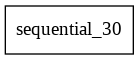

In [71]:
movie_title_model = tf.keras.Sequential([movie_title_lookup, movie_title_embedding])
# Plotting to see the layer structure
tf.keras.utils.plot_model(movie_title_model, "feature_embedding.png", show_shapes=True)

In [72]:
movie_title_model(["Star Wars (1977)"])

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.02903925,  0.03125986, -0.01744293,  0.03289101,  0.04234148,
         0.04654813, -0.04199805, -0.04220592, -0.04924312,  0.01788295,
         0.00597041, -0.00425719, -0.01224667,  0.03191772, -0.00694222,
         0.02813366, -0.01937916, -0.00431276,  0.00313948,  0.00871725,
        -0.04787344, -0.01808835, -0.00420644, -0.02825746, -0.00185551,
         0.01179639,  0.00746846, -0.02342722, -0.0318346 , -0.03124411,
        -0.02804931, -0.01315079,  0.03993925, -0.04091936,  0.0294173 ]],
      dtype=float32)>

### Applying on user id

In [75]:
user_id_lookup = tf.keras.layers.StringLookup()
user_id_lookup.adapt(ratings_new.map(lambda x: x["user_id"]))

user_id_embedding = tf.keras.layers.Embedding(user_id_lookup.vocabulary_size(), 35)

user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])

### Applying on movie genres

In [ ]:
genre_lookup = tf.keras.layers.StringLookup()
genre_lookup.adapt(ratings_new.map(lambda x: x["movie_genres"]))

genre_embedding = tf.keras.layers.Embedding(genre_lookup.vocabulary_size(), 35)

genre_model = tf.keras.Sequential([genre_lookup, genre_embedding])